In [16]:
# importowanie potrzebnych bibliotek:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#-------------------------------------------------------
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.DataStructs.cDataStructs import ExplicitBitVect
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from tqdm import tqdm
#--------------------------------------------------------
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import time
from sklearn.model_selection import ShuffleSplit, cross_validate,train_test_split
#--------------------------------------------------------
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [3]:
termo_database = pd.read_excel('C:/Users/mbkil/excele/Database _500.xlsx') 
termo_database.head()

# importujemy wykonaną przez nas baze danych

,Unnamed: 0,CAS,Substances,Molecular Weight [g/mol],Formula,SMILES,Critical_Temperature,Critical_Pressure,Critical_Volume
0,1,74-99-7,Propyne,40.06,C3H4,C#CC,401.10,5627.59,0.164
1,2,74-99-7,Propyne,40.06,C3H4,C#CC,402.40,5630.00,0.164
2,3,75-28-5,Isobutane,58.12,C4H10,CC(C)C,407.69,3604.00,0.259
3,4,106-98-9,1-Butene,56.11,C4H8,C=CCC,417.15,4000.00,0.241
4,5,115-11-7,2-Methylpropene,56.11,C4H8,C=C(C)C,417.88,4000.00,0.239


In [4]:
termo_baza_podstawa = termo_database[["Critical_Temperature","Critical_Pressure","Critical_Volume","SMILES"]]
termo_baza_podstawa

# wyodrębniamy interesujące nas dane

,Critical_Temperature,Critical_Pressure,Critical_Volume,SMILES
0,401.10,5627.59,0.164,C#CC
1,402.40,5630.00,0.164,C#CC
2,407.69,3604.00,0.259,CC(C)C
3,417.15,4000.00,0.241,C=CCC
4,417.88,4000.00,0.239,C=C(C)C
...,...,...,...,...
987,957.28,1793.94,0.872,CCCOC(=O)CCCC(=O)Oc1cc(C)ccc1C
988,965.52,1379.91,1.044,CCCCCCCCCCCOc1cc(Cl)c(Cl)cc1Cl
989,966.58,1616.77,0.946,CCCCCOC(=O)CCCC(=O)OCc1ccccc1F
990,968.16,1155.35,1.141,CCCCCCCCCCCOC(=O)CC(=O)OCCC(C)C


In [5]:
# tworzymy struktury 2d dla naszych SMILESÓW
PandasTools.AddMoleculeColumnToFrame(termo_baza_podstawa,'SMILES','Stucture',includeFingerprints=True)

C:\Users\mbkil\anaconda3\lib\site-packages\rdkit\Chem\PandasTools.py:381: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(


,Critical_Temperature,Critical_Pressure,Critical_Volume,SMILES,Stucture
0,401.10,5627.59,0.164,C#CC,
1,402.40,5630.00,0.164,C#CC,
2,407.69,3604.00,0.259,CC(C)C,
3,417.15,4000.00,0.241,C=CCC,
4,417.88,4000.00,0.239,C=C(C)C,
...,...,...,...,...,...
987,957.28,1793.94,0.872,CCCOC(=O)CCCC(=O)Oc1cc(C)ccc1C,
988,965.52,1379.91,1.044,CCCCCCCCCCCOc1cc(Cl)c(Cl)cc1Cl,
989,966.58,1616.77,0.946,CCCCCOC(=O)CCCC(=O)OCc1ccccc1F,
990,968.16,1155.35,1.141,CCCCCCCCCCCOC(=O)CC(=O)OCCC(C)C,

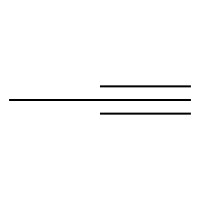
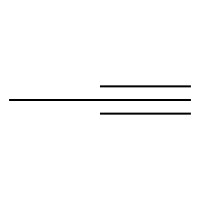
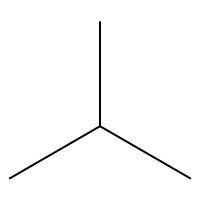
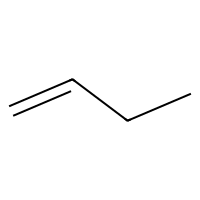
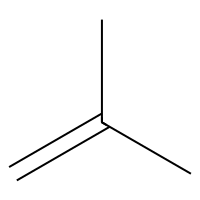
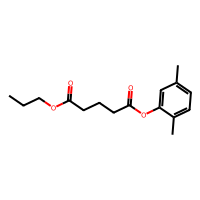
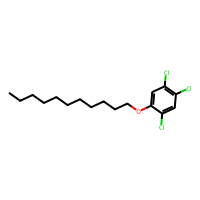
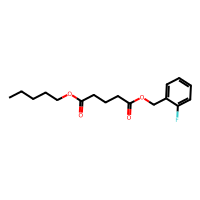
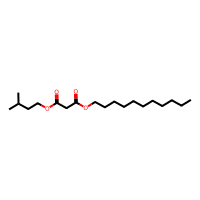
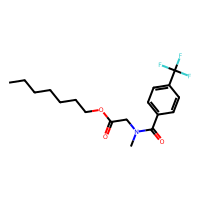

In [6]:
termo_baza_podstawa

In [7]:
def generate_AVfpts(data):
    
    Avalon_fpts = []
    
    for mol in tqdm(data):
      
        avfpts = pyAvalonTools.GetAvalonFP(mol, nBits=2048)
        Avalon_fpts.append(avfpts)
        
    return np.array(Avalon_fpts)

# Tworzymy fingerprinty

In [8]:
Avalon_fpts = generate_AVfpts(termo_baza_podstawa['Stucture'])

100%|██████████| 992/992 [00:00<00:00, 2518.15it/s]


In [9]:
Avalon_fpts

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [10]:
# Przchowujemy fingerprinty w nowej bazie

Avalon_fingerprints = pd.DataFrame(Avalon_fpts, columns=['Col_A_{}'.format(i + 1) 
                                                        for i in range(Avalon_fpts.shape[1])])
Avalon_fingerprints

Avalon_fingerprints.to_excel("Avalon_fingerprints.xlsx", index=False)

In [11]:
Avalon_fingerprints

,Col_A_1,Col_A_2,Col_A_3,Col_A_4,Col_A_5,Col_A_6,Col_A_7,Col_A_8,Col_A_9,Col_A_10,...,Col_A_2039,Col_A_2040,Col_A_2041,Col_A_2042,Col_A_2043,Col_A_2044,Col_A_2045,Col_A_2046,Col_A_2047,Col_A_2048
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
988,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


C:\Users\mbkil\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l1: 82.3625
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's l1: 77.6973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's l1: 74.2558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's l1: 70.4479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's l1: 66.7827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's l1: 63.4358
[LightGB

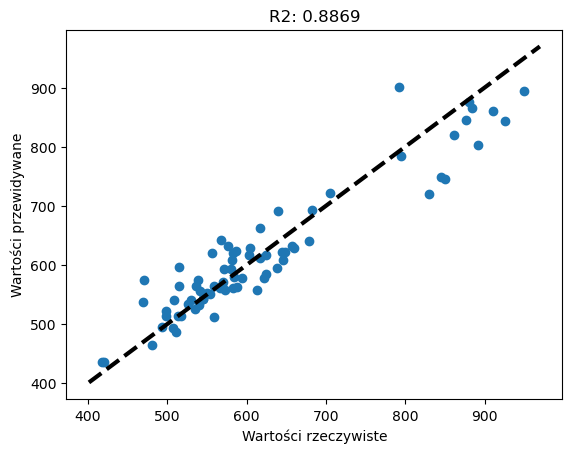

In [109]:
# pobranie kolumny TC i przekształcenie do tablicy numpy
y = termo_baza_podstawa["Critical_Temperature"].values

# wczytanie danych z arkusza "finger" i przekształcenie do tablicy numpy
X = Avalon_fingerprints.values

# Podział danych na zbiór treningowy, walidujący i testowy
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.15, random_state=24)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=24)

# utworzenie obiektu Dataset dla danych treningowych i walidacyjnych
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

# ustawienia modelu LightGBM
params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 512,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'verbose_eval': True
}

# trenowanie modelu
model = lgb.train(params, train_data, num_boost_round=700, valid_sets=[val_data],
                  early_stopping_rounds=500)

# predykcja na zbiorze testowym
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# ocena modelu
mea = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MEA: {mea:.4f}")
print(f"R2: {r2:.4f}")

# wykres predykcji vs rzeczywiste wartości dla zbioru testowego
plt.scatter(y_test, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)
plt.xlabel('Wartości rzeczywiste')
plt.ylabel('Wartości przewidywane')
plt.title(f"R2: {r2:.4f}")
plt.show()